<center><h2>ALTeGraD 2024<br>Lab Session 2: Transfer learning for NLP</h2> 15 / 10 / 2024<br> Dr. G. Shang, Y. Zhang<br><br>


<b>Student name:</b> GRAVIER Thomas

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 22, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

### The Model

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
        '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken, nhid)  # Embedding: (batch_size, seq_len) -> (batch_size, seq_len, nhid)
        self.pos_encoder = PositionalEncoding(nhid)
        encoder_layers = nn.TransformerEncoderLayer(nhid, nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        # Générer un masque carré basé sur la taille de la séquence (sz = sequence_length)
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        # src: (batch_size, seq_length)
        src = self.encoder(src) * math.sqrt(self.nhid)  # Embedding et scalage
        src = self.pos_encoder(src)  # Ajout de l'encodage positionnel
        output = self.transformer_encoder(src, src_mask)  # Transformer avec masque
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)  # Projeter vers le nombre de classes
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)  # (batch_size, nhid) -> (batch_size, nclasses)
        return output


class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self, src, src_mask):
        # Passer par le modèle Transformer
        x = self.base(src, src_mask)
        # Pour la classification, on utilise uniquement le dernier vecteur de la séquence
        output = nn.functional.softmax(self.classifier(x), dim=-1)  # (batch_size, nhid) -> (batch_size, nclasses)
        return output


In [4]:

class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


Let's verify if our model works, by applying one inference step

In [5]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape? yes

C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([1, 6, 100])


C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


## Vocabulary and Tokenization

In [6]:
import urllib.request

# Télécharger le fichier dict.txt
url = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt'
urllib.request.urlretrieve(url, 'dict.txt')

# Lire et afficher les 5 premières lignes du fichier
with open('dict.txt', 'r', encoding='utf-8') as f:
    for i in range(10):
        print(f.readline().strip())


▁d 1
es 1
▁l 1
en 1
on 1
▁p 1
▁de 1
▁s 1
▁c 1
an 1


In [7]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        
        token2ind[word] =  idx + 4 #fill me
     

ind2token = {v: k for k, v in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [8]:


import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r", encoding='utf-8') as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r", encoding='utf-8') as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [token2ind["<sos>"]]#fill me (constract the input sequence using token2ind, sequence and special tokens)
        source_sequence +=  [self.token2ind.get(token, self.token2ind["<oov>"]) for token in sequence ]
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [9]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1, :, :] #fill me
        output = output.view(-1, output.shape[-1])
        target = data[1] #fill me
        target = target.to(device)
        loss = criterion(output, target) #fill me, Cross entropy check next cells
        loss.backward() #fill me step 3

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        optimizer.step() #fill me step 4

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [10]:
ntokens = len(token2ind)#fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [11]:
len(token2ind)

50001

In [12]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# Télécharger le fichier dict.txt
#url = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt'
#urllib.request.urlretrieve(url, 'pretraining_subset.txt')

path_data_train = "pretraining_subset.txt"

In [15]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling", # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 10.80692 | ppl 49361.374


KeyboardInterrupt: 

## Text Generation


In [16]:


import urllib.request

# Télécharger le fichier dict.txt
url = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt'
urllib.request.urlretrieve(url, 'pretrained_model_4layers.pt')

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

C:\Users\DAO.EZSPACE\anaconda3\envs\mva2\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_20364\685277671.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will 

<All keys matched successfully>

In [17]:
# !pip install sentencepiece   # uncomment this if you are using google colab


# Télécharger le fichier dict.txt
url = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model'
urllib.request.urlretrieve(url, 'sentencepiece.french.model')

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [18]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(out[-1], dim=-1).item() # fill me 
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    model.eval()
    
    # Initialiser la séquence avec la phrase donnée
    for _ in range(max_len):  # Limiter la longueur à max_len
        # Utiliser la fonction infer_next_token pour prédire le prochain token
        next_token_ind, _ = infer_next_token(sent)  # Utiliser la phrase actuelle pour prédire le prochain token
        
        # Ajouter le token prédit à la phrase
        sent += " " + ind2token[next_token_ind]  # Convertir l'indice en token et l'ajouter à la phrase
        
        # Si le modèle prédit <eos>, arrêter la génération
        if next_token_ind == token2ind['<eos>']:
            break
    
    # Retourner la phrase complète générée
    return sent



In [48]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les ▁gens ▁qui ▁ont ▁été ▁très ▁accueillants ▁et ▁sympathiques . <eos>'

### Supervised task

In [49]:
import urllib.request

# Télécharger le fichier 'train.review.spm'
url_train_review = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm'
urllib.request.urlretrieve(url_train_review, 'train.review.spm')

# Télécharger le fichier 'train.label'
url_train_label = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label'
urllib.request.urlretrieve(url_train_label, 'train.label')

# Télécharger le fichier 'test.review.spm'
url_test_review = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm'
urllib.request.urlretrieve(url_test_review, 'test.review.spm')

# Télécharger le fichier 'test.label'
url_test_label = 'https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label'
urllib.request.urlretrieve(url_test_label, 'test.label')


path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

In [55]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    model.eval()
    
    running_corrects = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
            input = data[0].to(device)
            output = model(input, src_mask) # (2000, b_size, nclasses)
            preds = output[-1, :, :]
            labels = data[1].to(device)
            running_corrects += torch.sum(preds.argmax(dim=1) == labels)
    
    epoch_acc = running_corrects.double() / len(data_loader.dataset)

    return epoch_acc
    #to be implemented

In [56]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [57]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.73545 | ppl    2.086
| epoch   1 |   100/  200 steps | loss 0.70963 | ppl    2.033
| epoch   1 |   150/  200 steps | loss 0.70056 | ppl    2.015
| epoch   2 |    50/  200 steps | loss 0.65201 | ppl    1.919
| epoch   2 |   100/  200 steps | loss 0.66267 | ppl    1.940
| epoch   2 |   150/  200 steps | loss 0.61686 | ppl    1.853
| epoch   3 |    50/  200 steps | loss 0.57836 | ppl    1.783
| epoch   3 |   100/  200 steps | loss 0.53917 | ppl    1.715
| epoch   3 |   150/  200 steps | loss 0.51172 | ppl    1.668
| epoch   4 |    50/  200 steps | loss 0.43203 | ppl    1.540
| epoch   4 |   100/  200 steps | loss 0.44320 | ppl    1.558
| epoch   4 |   150/  200 steps | loss 0.42876 | ppl    1.535
| epoch   5 |    50/  200 steps | loss 0.39173 | ppl    1.480
| epoch   5 |   100/  200 steps | loss 0.39566 | ppl    1.485
| epoch   5 |   150/  200 steps | loss 0.36490 | ppl    1.440
| epoch   6 |    50/  200 steps | loss

C:\Users\DAO.EZSPACE\AppData\Local\Temp\ipykernel_20364\89992632.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4layers_no_cl

| epoch   1 |    50/  200 steps | loss 0.68963 | ppl    1.993
| epoch   1 |   100/  200 steps | loss 0.61686 | ppl    1.853
| epoch   1 |   150/  200 steps | loss 0.60886 | ppl    1.838
| epoch   2 |    50/  200 steps | loss 0.54998 | ppl    1.733
| epoch   2 |   100/  200 steps | loss 0.53960 | ppl    1.715
| epoch   2 |   150/  200 steps | loss 0.49756 | ppl    1.645
| epoch   3 |    50/  200 steps | loss 0.46801 | ppl    1.597
| epoch   3 |   100/  200 steps | loss 0.44405 | ppl    1.559
| epoch   3 |   150/  200 steps | loss 0.43515 | ppl    1.545
| epoch   4 |    50/  200 steps | loss 0.40355 | ppl    1.497
| epoch   4 |   100/  200 steps | loss 0.39322 | ppl    1.482
| epoch   4 |   150/  200 steps | loss 0.39936 | ppl    1.491
| epoch   5 |    50/  200 steps | loss 0.35059 | ppl    1.420
| epoch   5 |   100/  200 steps | loss 0.35973 | ppl    1.433
| epoch   5 |   150/  200 steps | loss 0.38514 | ppl    1.470
| epoch   6 |    50/  200 steps | loss 0.35071 | ppl    1.420
| epoch 

In [ ]:
#Visualize the accuracy

In [58]:
#Visualize the accuracy
import matplotlib.pyplot as plt
import numpy as np

from_scratch_valid_acc_processed = [acc.cpu().numpy() for acc in from_scratch_valid_acc]
pretrained_valid_acc_processed = [acc.cpu().numpy() for acc in pretrained_valid_acc]

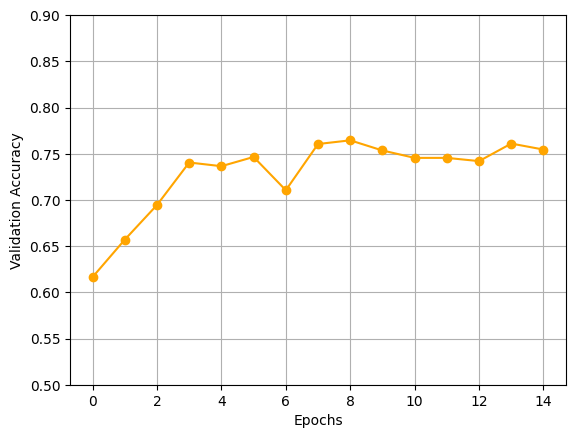

In [67]:
import os

# Ensure the directory exists
save_dir = "./figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Plotting
plt.plot(from_scratch_valid_acc_processed, marker='o', color='orange')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.ylim(0.5, 0.9)

# Save the figure
plt.savefig(os.path.join(save_dir, "from_scratch_val_acc.pdf"))
plt.show()


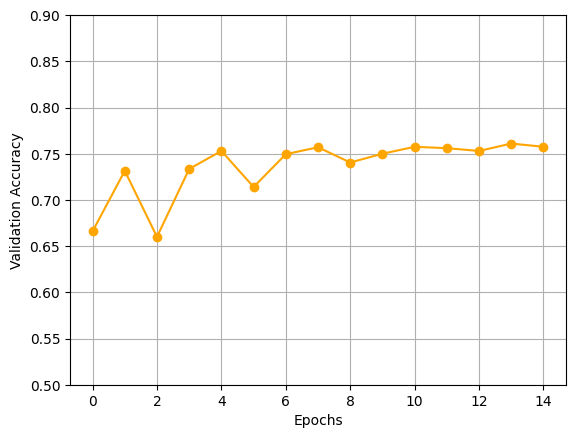

In [69]:
import os

# Ensure the directory exists
save_dir = "./figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Plotting
plt.plot(pretrained_valid_acc_processed, marker='o', color='orange')
plt.grid(True)
plt.xlabel('Epochs')  # Capitalized 'epochs'
plt.ylabel('Validation Accuracy')  # Corrected to 'Validation Accuracy'
plt.ylim(0.5, 0.9)

# Save the figure
plt.savefig(os.path.join(save_dir, "pretrained_val_accs.pdf"))  # Fixed file name

plt.show()
